# Evaluation notebook
This notebook serves as an evaluation environment for the data obtained during the experiments. It is quite specifically tailored to that data, relying on its naming conventions and storage paths, however, it should be reusable and extensible enough to be used for any future experiment evaluations.

In [258]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from glob import glob
import csv
import scipy.signal as sg

## Cartpole evaluation

In [259]:
# first, source the csv files
RUN_DIR = './cartpole_eval'
run = sorted(glob(RUN_DIR + '/*/*.csv'))

def strip_run_name(name):
    ret = name.split('/')[-2].split('_')[0]
    return ret

def get_data(run, strip=False):
    data = []
    for f in run:
        generations = []
        with open(f) as csvfile:
            spamreader = csv.reader(csvfile, delimiter=';')
            for row in spamreader:
                generations.append(np.array(row, dtype='float32'))
        generations = np.stack(generations)
        if strip:
            data.append((strip_run_name(f), generations))
        else:
            data.append((f, generations))
    return data

cartpole_data = sorted(get_data(run, strip=True), key=lambda x: int(x[0].split(':')[1]))

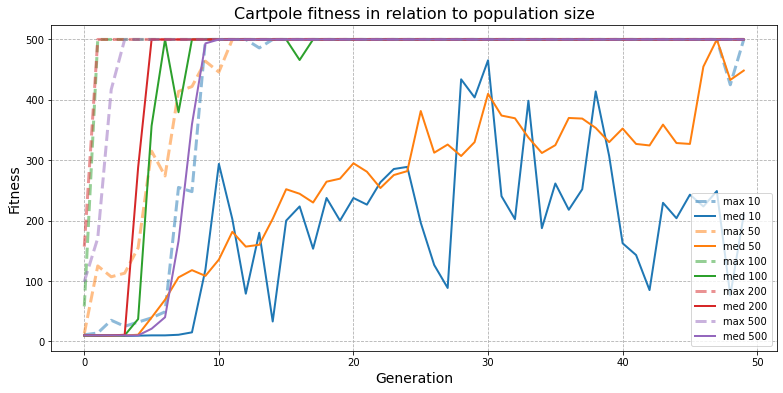

In [260]:
# plot all the runs into a single figure
plt.figure(figsize=(13, 6))
for name, data in cartpole_data:
    max_fit = np.max(data, axis=1)
    med_fit = np.median(data, axis=1)
    p = plt.plot(max_fit, label='max ' + name.split(':')[1], linewidth=3.0, alpha=0.5, linestyle='--')
    plt.plot(med_fit, color=p[0].get_color(), label='med ' + name.split(':')[1], linewidth=2.0)
    
plt.xlabel('Generation', fontsize=14)
plt.ylabel('Fitness', fontsize=14)
plt.legend()
plt.title('Cartpole fitness in relation to population size', fontsize=16)
plt.grid(visible=True, linestyle='--')
plt.savefig('./doc/cartpole_psize.pdf')
plt.show()

## Bipedal walker evaluation
This part of the notebook is not replicable. The data used here is too big to add it to the final archive. If that would be a problem
I can always provide a download link that would download all this required data.

In [261]:
# first, source the csv files
CSV_DIR = './runs'
first_run = sorted(glob(CSV_DIR + '/*adan.csv'))
second_run = sorted(glob(CSV_DIR + '/*adan_2.csv'))


data_fst = get_data(first_run)
data_snd = get_data(second_run)

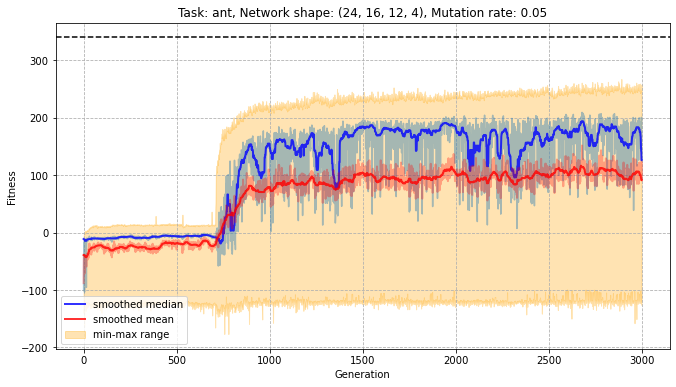

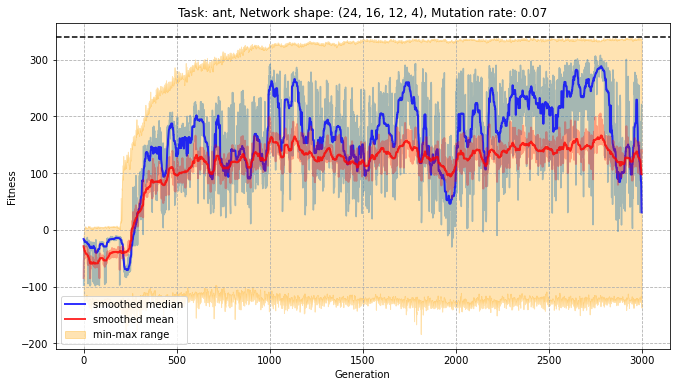

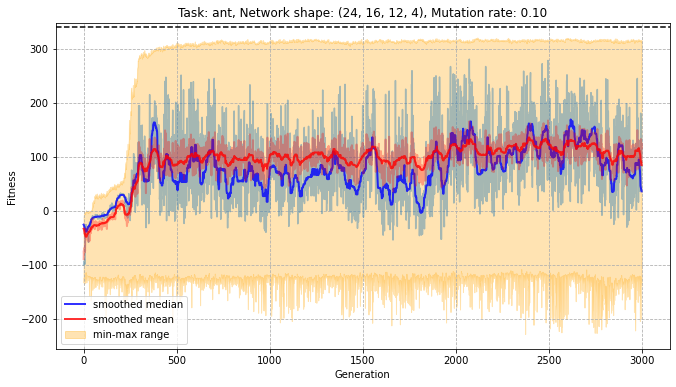

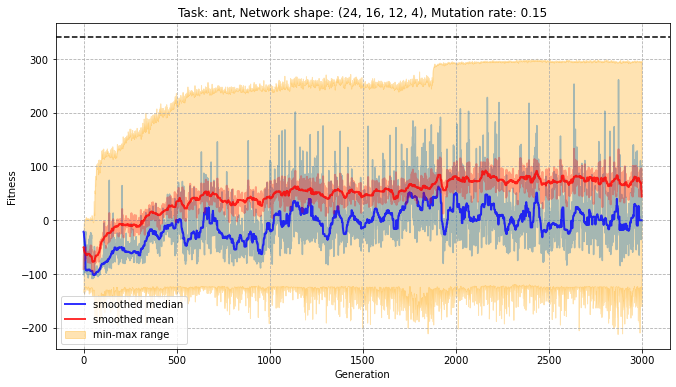

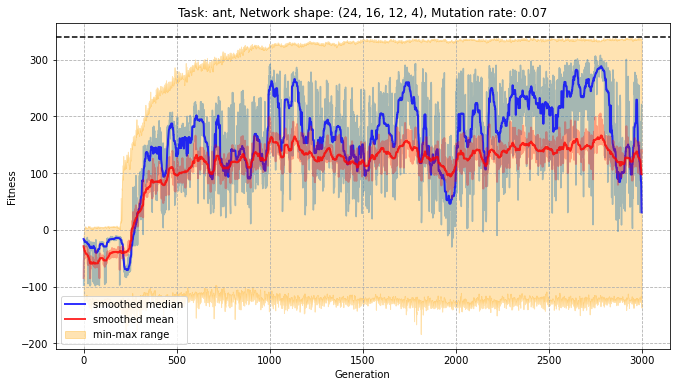

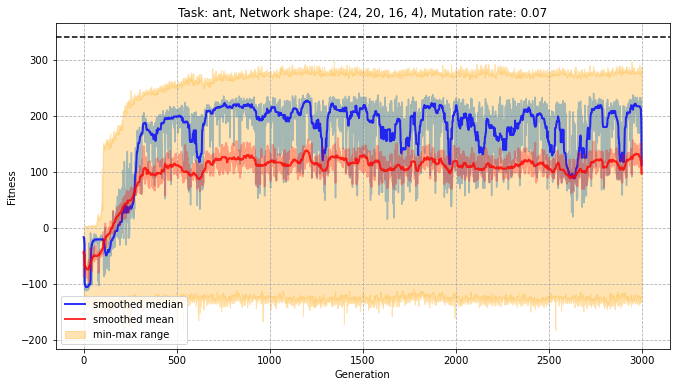

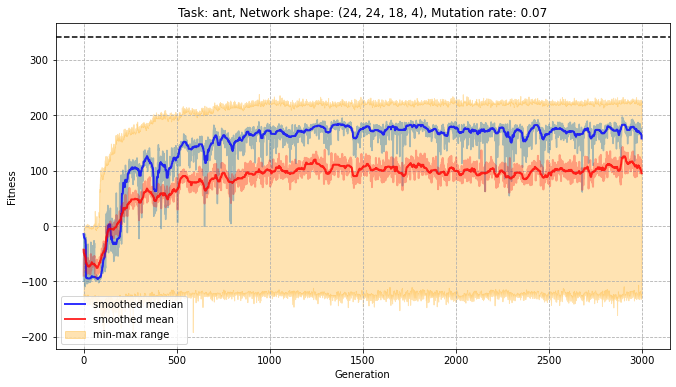

In [262]:
def strip_csv_name(name):
    return name.rpartition('/')[2].rpartition('.')[0].partition('_')[2].partition('_a')[0]

def ant_csv_name_to_params(name):
    task, _, rest = name.partition('_')
    net, _, m_rate = rest.rpartition('_')
    first_layer, second_layer = net.split('_')
    net_tuple = (24, int(first_layer), int(second_layer), 4)
    return f"Task: {task}, Network shape: {net_tuple}, Mutation rate: {m_rate}"
    
def plot_convergence(name, data):
    KERNEL_SIZE = 31
    MAX_FITNESS = 340
    min_fit = np.min(data, axis=1)
    max_fit = np.max(data, axis=1)
    med_fit = np.median(data, axis=1)
    mean_fit = np.mean(data, axis=1)
    
    xaxis = np.arange(med_fit.size)
    plt.figure(figsize=(11, 6))
    
    plt.plot(med_fit, alpha=0.4)
    plt.plot(sg.medfilt(med_fit, kernel_size=KERNEL_SIZE), color='blue', linewidth=2.0, alpha=0.8, label='smoothed median')
    
    plt.plot(mean_fit, color='red', linewidth=2.0, alpha=0.3)
    plt.plot(sg.medfilt(mean_fit, kernel_size=KERNEL_SIZE), color='red', linewidth=2.0, alpha=0.8, label='smoothed mean')
    
    plt.fill_between(xaxis, min_fit, max_fit, alpha=0.3, color='orange', label='min-max range')
    
    plt.axhline(MAX_FITNESS, color='black', linestyle='--')
    
    plt.xlabel('Generation')
    plt.ylabel('Fitness')
    plt.legend()
    plt.grid(visible=True, linestyle='--')
    plt.title(ant_csv_name_to_params(strip_csv_name(name)))
    plt.savefig(f'./doc/{strip_csv_name(name)}.pdf')
    plt.show()

mr_runs = list(filter(lambda n: 'ant_2' not in n[0], data_snd))
net_size_runs = list(filter(lambda n: '0.07' in n[0], data_snd))
for data in mr_runs:
    plot_convergence(*data)
for data in net_size_runs:
    plot_convergence(*data)


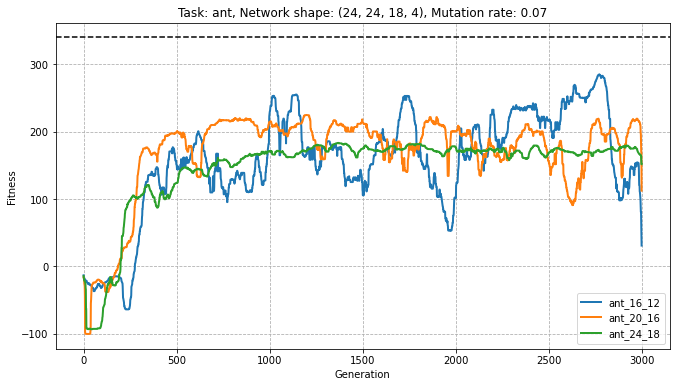

In [263]:
# plot the median fitness comparison for the different network architectures
KERNEL_SIZE = 51 
MAX_FITNESS = 340
plt.figure(figsize=(11, 6))
for (name, run), color in zip(net_size_runs, ['blue', 'red', 'green']):
    med_fit = np.median(run, axis=1)
    #plt.plot(med_fit, alpha=0.4, color=color)
    plt.plot(sg.medfilt(med_fit, kernel_size=KERNEL_SIZE), linewidth=2.0, label=strip_csv_name(name)[:-5])

plt.axhline(MAX_FITNESS, color='black', linestyle='--')

plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.legend()
plt.grid(visible=True, linestyle='--')
plt.title(ant_csv_name_to_params(strip_csv_name(name)))
plt.savefig(f'./doc/median_fitness.pdf')
plt.show()

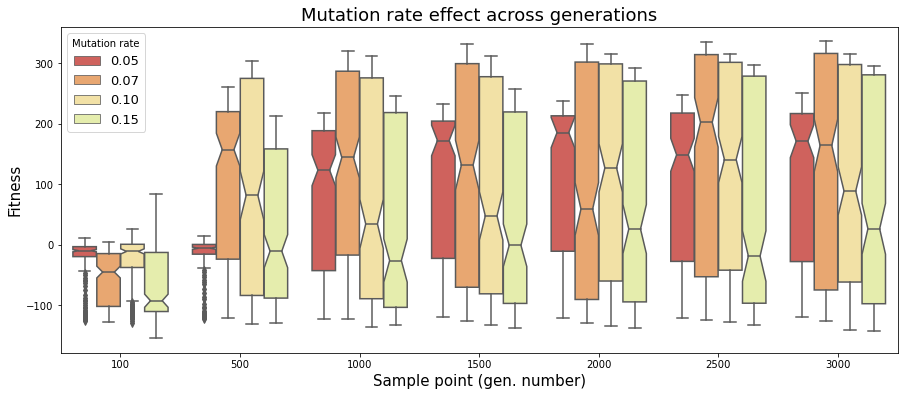

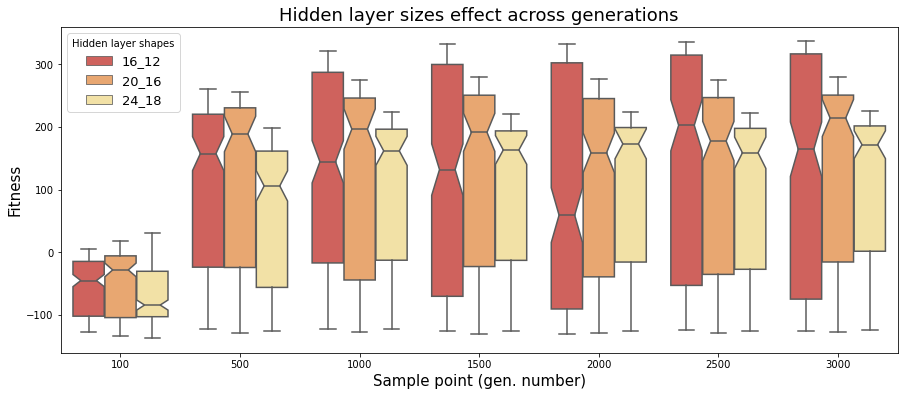

In [264]:
def compare_runs(run_list, average_size=50, title="", save='figure.pdf', legend_title='Hidden layer shapes'):
    
    # create an array of sample points
    sample_points = np.hstack((np.array([100]) ,np.arange(500, 3001, 500)))
    
    rs = []
    rns = []
    sps = []
    
    # for each sample point, average the last 100 generations
    for sp in sample_points:
        for name, run in run_list:
            r = list(np.mean(run[sp - average_size:sp], axis=0))
            rn = [ strip_csv_name(name) for _ in r ]
            rs.extend(r)
            if legend_title != 'Hidden layer shapes':
                rns.extend( [ rn_.rpartition('_')[2] for rn_ in rn ])
            else:
                rns.extend([ rn_.rpartition('_')[0].partition('_')[2] for rn_ in rn ])
            sps.extend([ sp for _ in r ])
            
    df = pd.DataFrame()
    df['sample_point'] = sps
    df['run_name'] = rns
    df['fitness'] = rs
    
    plt.figure(figsize=(15, 6))
    g = sns.boxplot(x="sample_point", y="fitness",
            hue="run_name", data=df, palette=sns.color_palette("Spectral"), notch=True)
    g.legend(title=legend_title, fontsize=13)
    g.set_title(title, fontsize=18)
    plt.xlabel('Sample point (gen. number)', fontsize=15)
    plt.ylabel('Fitness', fontsize=15)
    plt.savefig(f'./doc/{save}')
    #sns.despine(offset=5, trim=True)
    
    
mr_runs = list(filter(lambda n: 'ant_2' not in n[0], data_snd))
net_size_runs = list(filter(lambda n: '0.07' in n[0], data_snd))
compare_runs(mr_runs, title="Mutation rate effect across generations", save='mr_runs.pdf', legend_title='Mutation rate')
compare_runs(net_size_runs, title="Hidden layer sizes effect across generations", save='net_size_runs.pdf')